In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from IPython.display import display

## More Data cleaning

In [6]:
df = pd.read_csv("../data/interim/top200_hiphop_wpopscore.csv")

df.loc[:, 'artist'][1]

' Drake'

In [7]:
df.loc[:, 'artist'] = df.loc[:, 'artist'].str.strip()
df.columns

Index(['stream_count', 'track_id', 'title', 'artist', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'release_date', 'genre', 'release_year', 'has_top_artist_prevyear',
       'score_top_artist_prevyear'],
      dtype='object')

In [8]:
df.drop(columns = ['track_id', 'type', 'id', 'uri', 'track_href', 'analysis_url','release_year', 'genre'], inplace = True)

In [9]:
df.release_date = df.release_date.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").date() if len(x) > 4 else dt.datetime.strptime(x, "%Y").date())

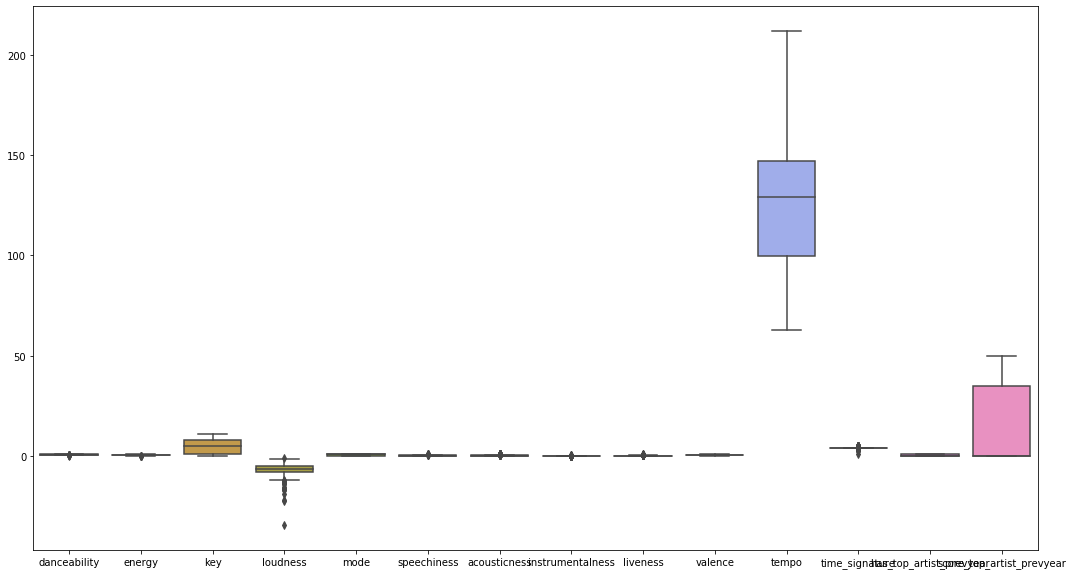

In [11]:
fig, axes = plt.subplots( figsize = (18,10))
sns.boxplot(data = df.drop(columns = ['stream_count', 'release_date', 'duration_ms']));

In [8]:
# Data clipping

def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range


outlier_treatment(df.stream_count)

(2235552.5, 6860900.5)

In [12]:
new_df = df[(df.stream_count > 2235552.5) & (df.stream_count < 6860900.5)]


In [13]:
outlier_treatment(df.duration_ms)

NameError: name 'outlier_treatment' is not defined

In [12]:
new_df = new_df[(new_df.duration_ms > 67801) & (new_df.duration_ms < 339417)]
len(new_df)

805

In [ ]:
#df.describe()
sns.pairplot(new_df);

## Split data into train, validation and test sets

In [13]:
# Separate features from target. Log transform y
X, y = new_df.drop(columns = ['stream_count', 'title', 'artist', 'release_date']), np.log(new_df['stream_count'])

In [14]:
# Split data into a train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)
#X_train, y_train = np.array(X_train), np.array(y_train)

## Data exploration

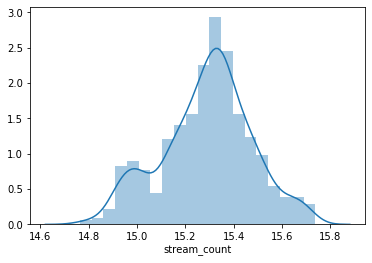

In [15]:
sns.distplot(y_train);

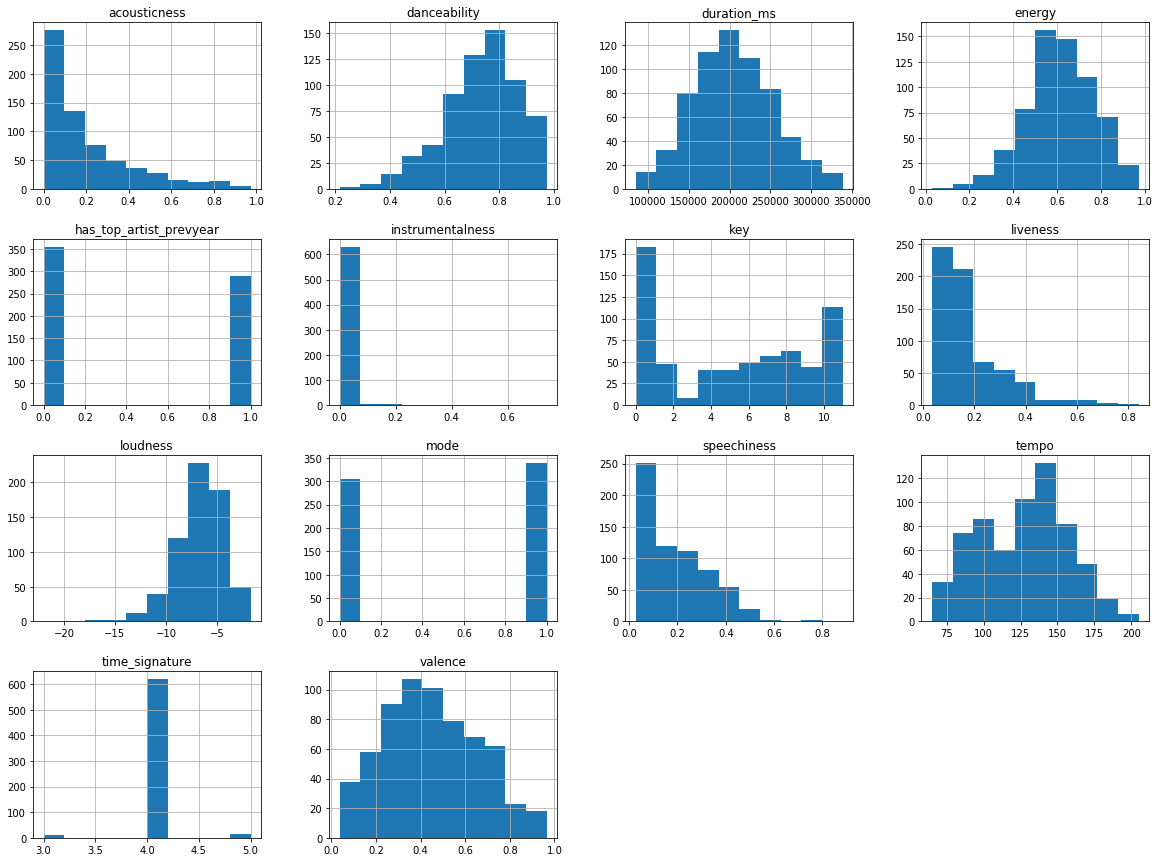

In [16]:
#fig, axes = plt.subplots(4,4, figsize = (18,10))

#counter = 0 
#for row in range(0,4):
#    for col in range(0,4):
#        if counter <= len(column_list):
#            ax = axes[row][col]
#            ax.hist(df[column_list[counter]]) 
#            ax.set_title('{}'.format(column_list[counter]))
#            counter += 1
            
#plt.tight_layout()
#plt.show();


pd.DataFrame.hist(X_train, figsize = [20,15]);

In [17]:
sorted(X_train.columns)

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'has_top_artist_prevyear',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

Loudness and energy probably shouldn't be included as features together.

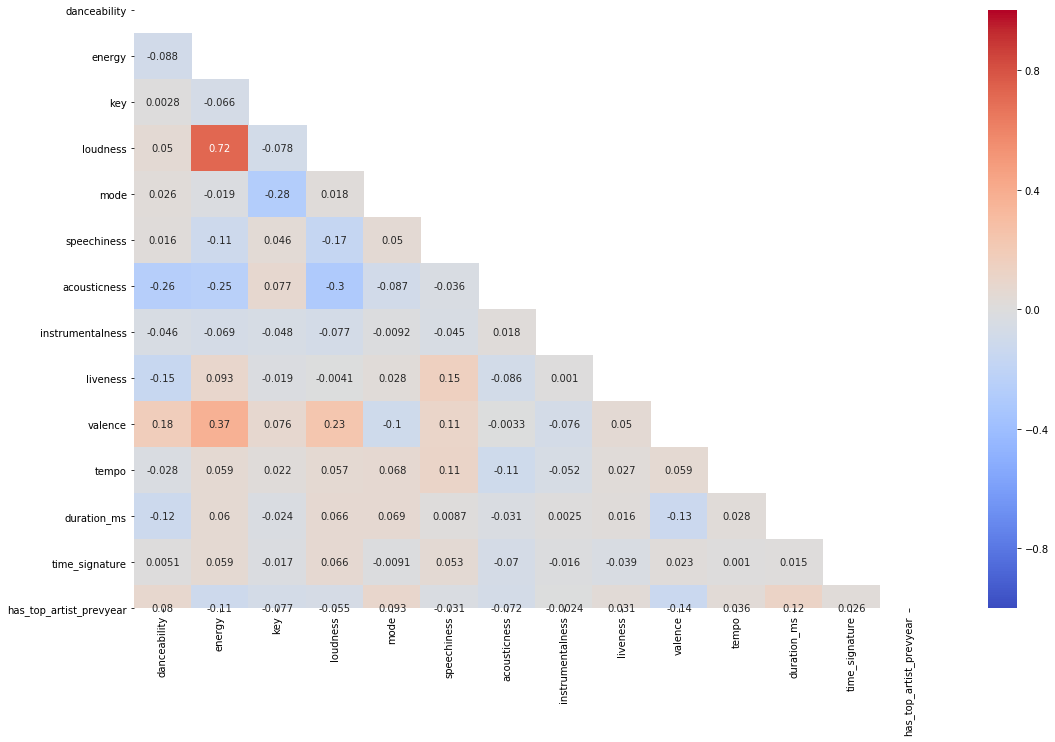

In [18]:
# Check for correlations between features

fig, ax = plt.subplots(figsize = (18,11))

mask = np.zeros_like(X_train.corr(), dtype = np.bool) # returns an array of zeros with shape of df.corr
mask[np.triu_indices_from(mask)] = True # sets left side of triangle to true
sns.heatmap(X_train.corr(), mask = mask, cmap = 'coolwarm', annot = True, vmin = -1, vmax = 1, ax =ax)

plt.show()

## Scale features 


In [36]:
#Might it be possible to use pipelines here?
kbest = SelectKBest(f_regression)
pipeline = Pipeline([
('scaler', RobustScaler()),
('kbest', kbest), 
('regr',LinearRegression())])
#grid_search = GridSearchCV(...


#scaler = RobustScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)


#X_train2 = X_train.assign(log_acousticness = np.log(X_train.acousticness))
#X_train2 = X_train2.assign(log_liveness = np.log(X_train.liveness))
#X_train2 = X_train2.assign(log_speechiness = np.log(X_train.speechiness))
#X_train2 = X_train2.assign(log_duration_ms = np.log(X_train.duration_ms))
#X_train2 = X_train2.drop(columns = ['liveness', 'speechiness', 'acousticness', 'duration_ms'])

train = X_train.join(y_train)
train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'has_top_artist_prevyear',
       'stream_count'],
      dtype='object')

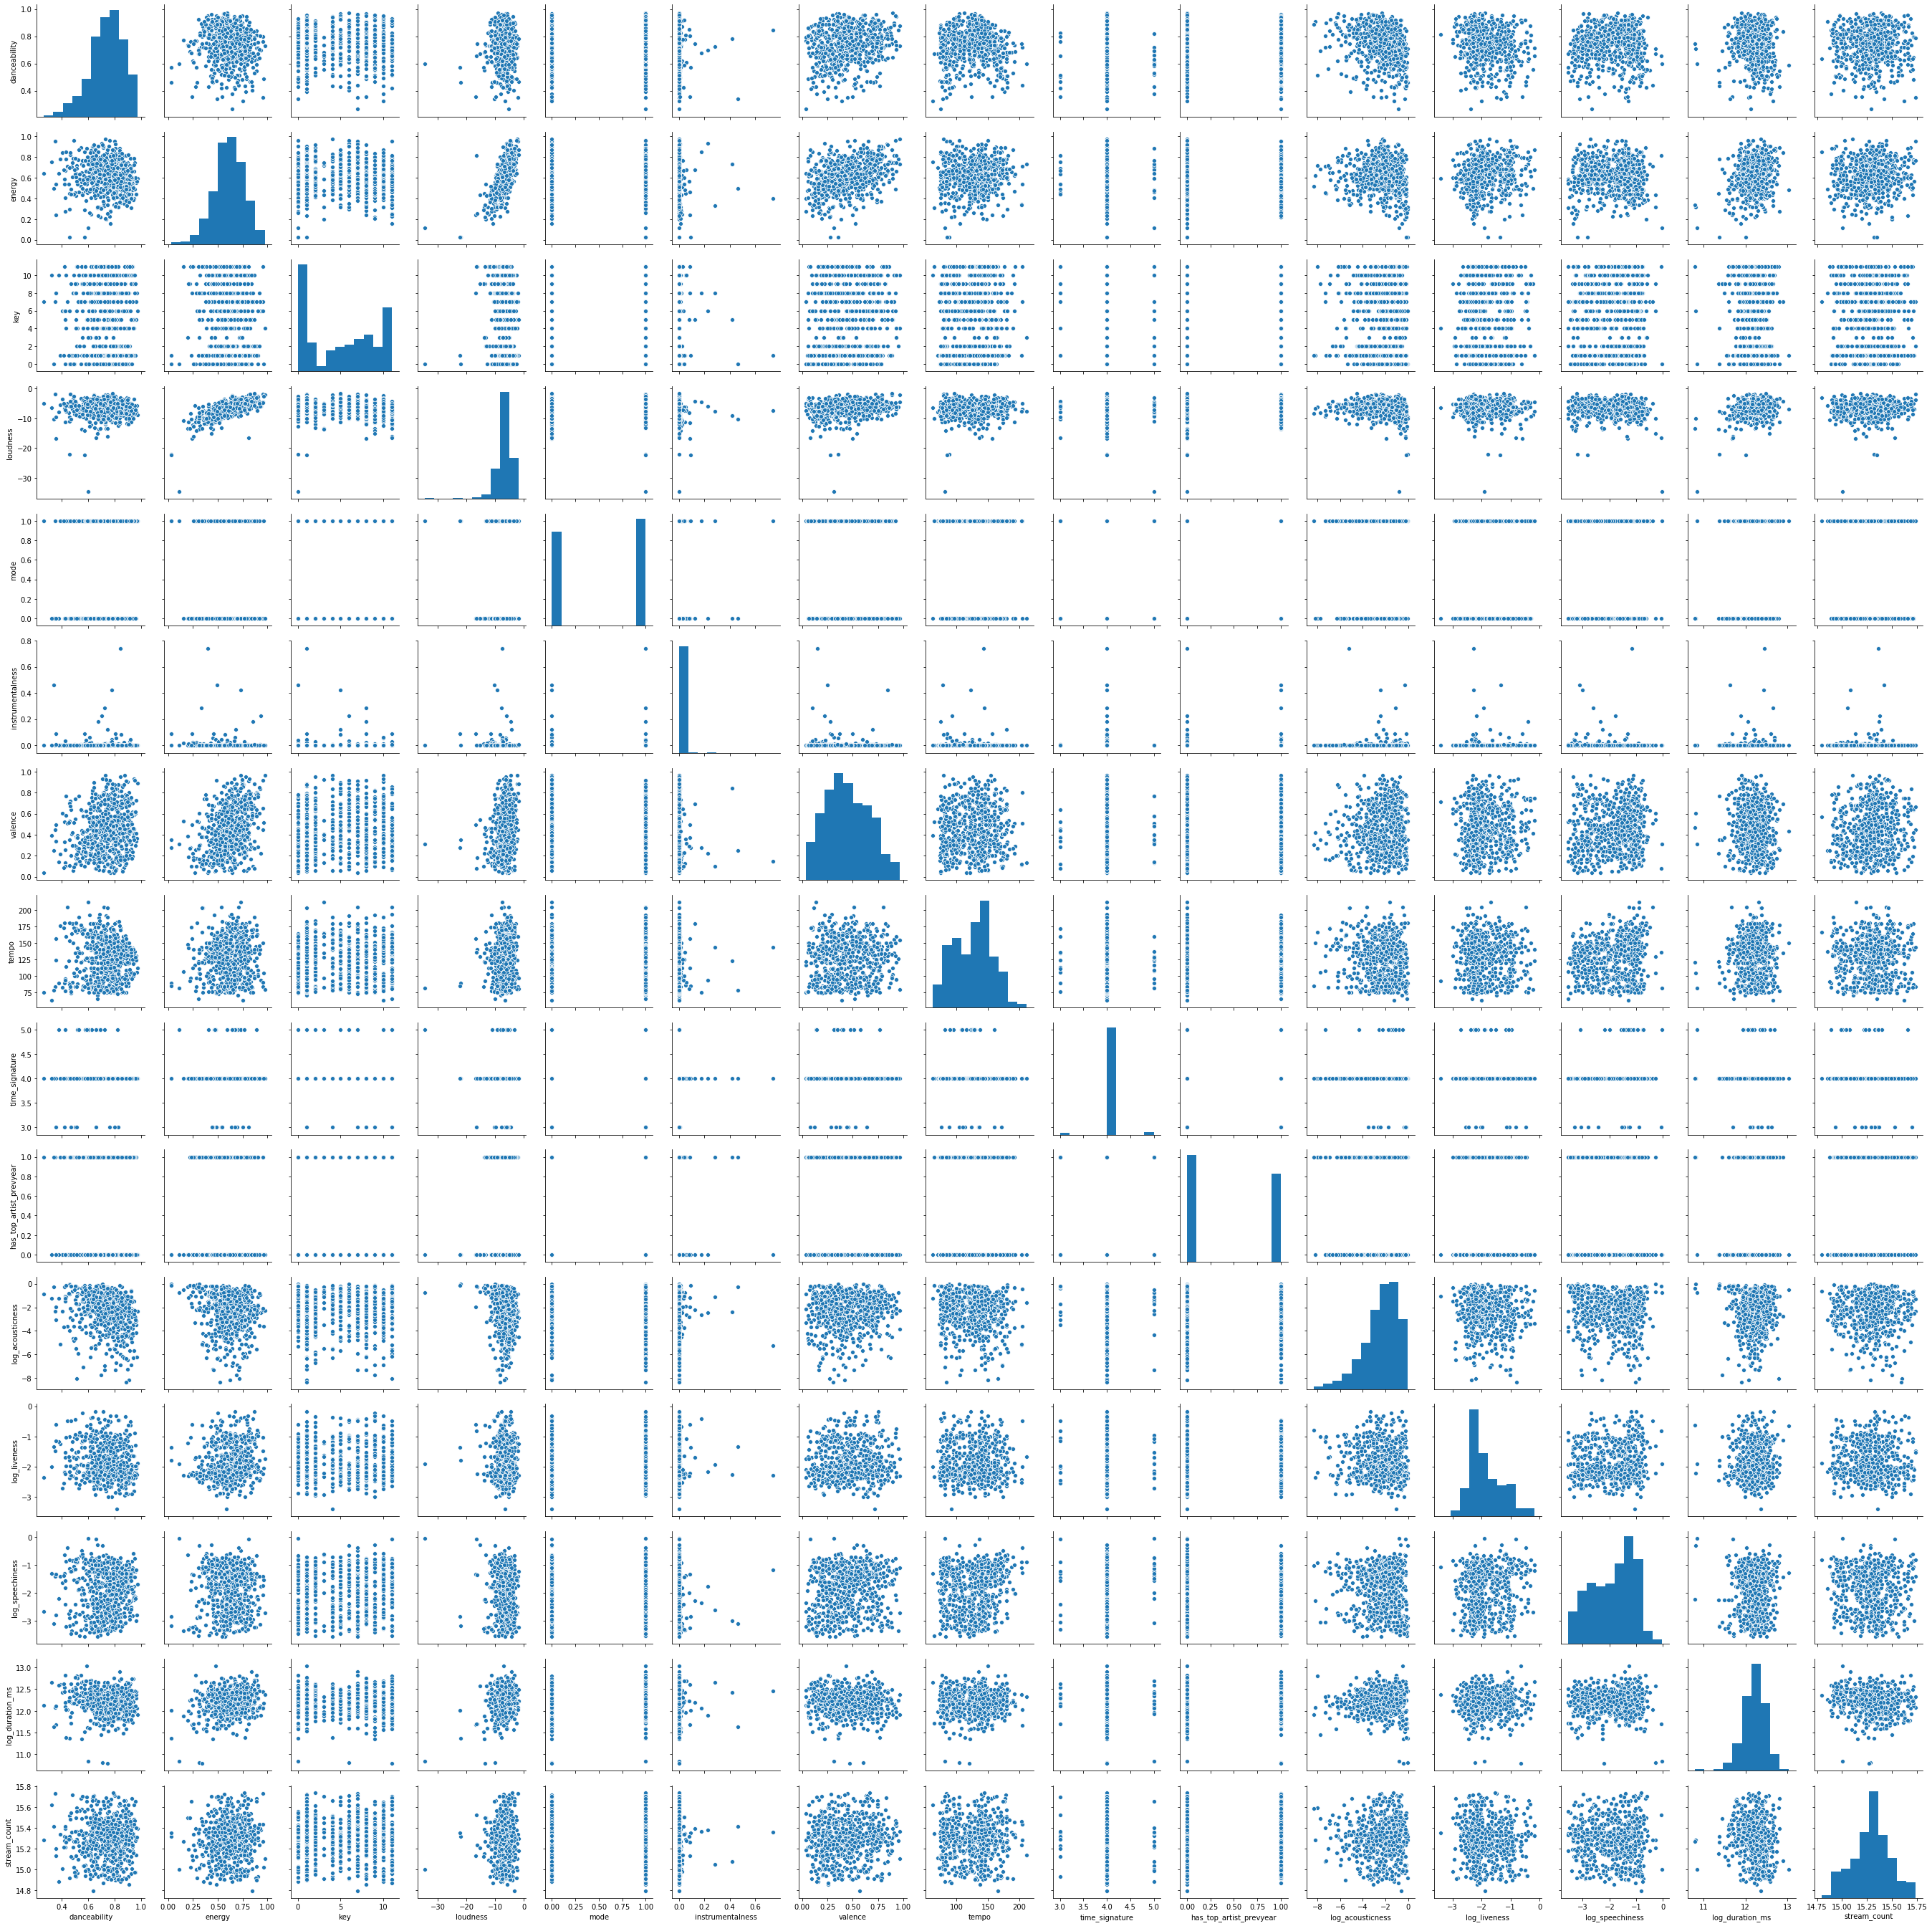

In [376]:
sns.pairplot(train);

## Features selection (within cross validation folds?)

In [343]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# without energy

y, X = patsy.dmatrices('stream_count ~ danceability + key + loudness + mode + instrumentalness + valence + tempo + log_duration_ms + time_signature + has_top_artist_prevyear + log_acousticness + log_liveness + log_speechiness' , data = train, return_type = 'dataframe')

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.244
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           8.86e-05
Time:                        16:18:52   Log-Likelihood:                 192.85
No. Observations:                 659   AIC:                            -357.7
Df Residuals:                     645   BIC:                            -294.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  17.2859      0.384     45.060      0.000      16.533      18.039
danceability               -0.0826      0.060     -1.372      0.171      -0.201       0.036
key                        -0.0001      0.002     -0.054      0.957      -0.004       0.004
loudness                    0.0110      0.003      3.677      0.000       0.005       0.017
mode                       -0.0003      0.015     -0.018      0.986      -0.031       0.030
instrumentalness            0.0496      0.172      0.288      0.773      -0.288       0.388
valence                     0.0431      0.037      1.165      0.244      -0.030       0.116
tempo                   -1.917e-05      0.000     -0.081      0.936      -0.000       0.000
log_duration_ms            -0.1357      0.027     -4.972      0.000      -0.189      -0.082
time_signature             -0.0610      0.038     -1.625      0.105      -0.135       0.013
has_top_artist_prevyear     0.0198      0.015      1.353      0.177      -0.009       0.049
log_acousticness            0.0036      0.005      0.726      0.468      -0.006       0.013
log_liveness               -0.0211      0.013     -1.640      0.102      -0.046       0.004
log_speechiness             0.0071      0.009      0.760      0.448      -0.011       0.026
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.723
Skew:                          -0.018   Prob(JB):                        0.697
Kurtosis:                       2.842   Cond. No.                     7.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Forward/backward filter method
#danceability + key + loudness + mode + instrumentalness + valence + tempo + log_duration_ms + time_signature + has_top_artist_prevyear + log_acousticness + log_liveness + log_speechiness' , data = train, return_type = 'dataframe')

model2 = smf.ols('stream_count ~ loudness + duration_ms', data = train)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     19.23
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           7.78e-09
Time:                        17:24:36   Log-Likelihood:                 187.49
No. Observations:                 644   AIC:                            -369.0
Df Residuals:                     641   BIC:                            -355.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.5159      0.038    410.036      0.000      15.442      15.590
loudness        0.0081      0.003      2.683      0.007       0.002       0.014
duration_ms -8.402e-07   1.46e-07     -5.754      0.000   -1.13e-06   -5.53e-07
==============================================================================
Omnibus:                        1.501   Durbin-Watson:                   2.253
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                1.570
Skew:                          -0.112   Prob(JB):                        0.456
Kurtosis:                       2.910   Cond. No.                     1.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Backwards filter method

model3 = smf.ols('stream_count ~  loudness + duration_ms + has_top_artist_prevyear' , data = train)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     13.02
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           2.91e-08
Time:                        17:21:21   Log-Likelihood:                 187.80
No. Observations:                 644   AIC:                            -367.6
Df Residuals:                     640   BIC:                            -349.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  15.5147      0.038    409.559      0.000      15.440      15.589
loudness                    0.0082      0.003      2.727      0.007       0.002       0.014
duration_ms             -8.545e-07   1.47e-07     -5.806      0.000   -1.14e-06   -5.66e-07
has_top_artist_prevyear     0.0115      0.014      0.791      0.429      -0.017       0.040
==============================================================================
Omnibus:                        1.390   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.457
Skew:                          -0.108   Prob(JB):                        0.483
Kurtosis:                       2.915   Cond. No.                     1.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# 'danceability', 'valence', 'loudness', 'duration_ms', 'time_signature', 'has_top_artist_prevyear','liveness'

X_train3 = X_train[['loudness', 'duration_ms', 'danceability', 'valence', 'time_signature', 'has_top_artist_prevyear','liveness']]
#X_train3 = X_train3.assign(log_duration_ms = np.log(X_train.duration_ms))
#X_train3 = X_train3.drop(columns = ['duration_ms'])

scaler = MinMaxScaler().fit(X_train3)

X_train3_scaled = scaler.transform(X_train3)

reg = LinearRegression().fit(X_train3_scaled, y_train)

print('R sq: ', reg.score(X_train3_scaled, y_train))
print('adj R sq: ', 1 - (1-reg.score(X_train3_scaled, y_train))*(len(y_train)-1)/(len(y_train)-X_train3_scaled.shape[1]-1))
print('coef: ', reg.coef_)


R sq:  0.0679747447033977
adj R sq:  0.05771660510107668
coef:  [ 0.15526038 -0.21349049 -0.04618495  0.05071111 -0.13100509  0.01692405
 -0.06042728]


In [34]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

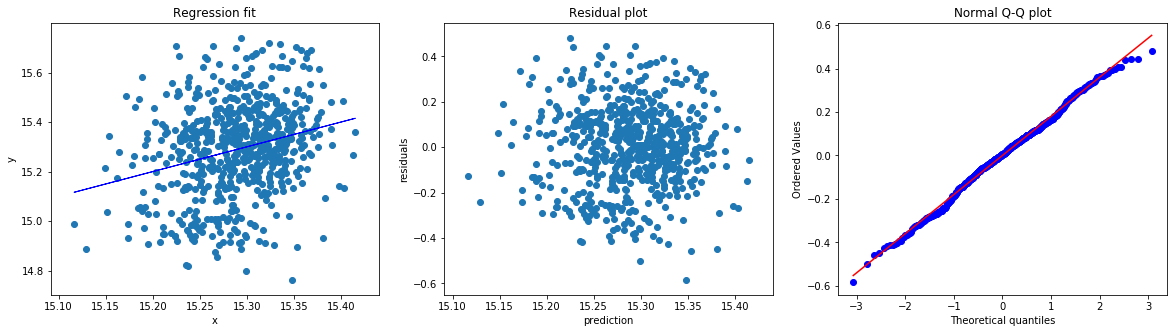

In [55]:
diagnostic_plot(reg.predict(X_train3_scaled).reshape(-1,1), y_train)

## Hyperparameters tuning and model selection